# Visualizations
The main purpose of this document is to create the graphs that will represent my analysis. 

# Analysis Ideas

## Forecasting daily rides
This one I am struggling to figure out.  We have panel data but all the factors I want to use are constant across time so the time variable doesn't really help us.  If we use a fixed effects/random effects/ dynamic model none of the variables of interest are useful as they do not vary over time.  We could add in weather data and predict the number of rides occuring at each station, but we then probably want to be more granular than daily rides.  Lots of problems here to be thought out.


## Forecasting station placement
This might be easier.  We are interested in increasing the total number of rides being taken.  We can look at new station placements and whether it increased total rides in the city or if it just led to substitutions or nothing at all.  So we could create a regression that has dummies for every time a station is added then us a clustering model to determine which features determine the stations that have high coefficients on their dummy variables.

In [1]:
from fitparse import FitFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import time
import glob
import requests
from json import JSONDecodeError
import folium
import math

# MAPS
With the maps below we can see a few interesting things.  Montreal is built on a mountain and we can see that the stations north of the mountain and the higher elevations have more trips began than trips ended.  Conversely the stations at low elevation near the river have more trips ended than trips began.  This suggests that elevation is important in determining how trips are determined.

In [2]:
df = pd.read_csv('station.csv')

df['marker_color'] = pd.cut(df['altitude'], bins = 5, 
                              labels=['teal','forestgreen', 'olivedrab', 'goldenrod' ,'darkorange'])
station_map = folium.Map(location=[45.5001, -73.5665], zoom_start=13)
for i in df.index:
    folium.CircleMarker( [df.iloc[i]['lat'],df.iloc[i]['long']], 
                        radius = 5, 
                        color = df.iloc[i]['marker_color'],
                       fill = False).add_to(station_map)
station_map

In [3]:
## First we will generate a dataframe that aggregates the trips by station and contains altitude and longitude
df = pd.read_csv('rides_by_station.csv',dtype = {'station_code': int , 
                                                 'date' : 'str' , 
                                                 'trips_began':int,
                                                  'trips_ended':float , 
                                                 'lat': float ,
                                                 'long' : float ,
                                                 'altitude': float},parse_dates = True)


maps = df.groupby(['station_code','lat','long','altitude'],as_index = False)['trips_began','trips_ended'].apply(lambda x : x.astype(int).mean()).reset_index()
maps['marker_color'] = pd.cut(maps['trips_began'], bins = 4, 
                              labels=['tab:blue', 'green','yellow' ,'red'])

station_map = folium.Map(location=[45.5001, -73.5665], zoom_start=13)
for i in maps.index:
    folium.CircleMarker( [maps.iloc[i]['lat'],maps.iloc[i]['long']], 
                        radius = 5, 
                        color = maps.iloc[i]['marker_color'],
                       fill = False).add_to(station_map)
station_map


In [4]:
maps['marker_color'] = pd.cut(maps['trips_ended'], bins = 4, 
                              labels=['None', 'green','yellow' ,'red'])

station_map = folium.Map(location=[45.5001, -73.5665], zoom_start=13)
for i in maps.index:
    folium.CircleMarker( [maps.iloc[i]['lat'],maps.iloc[i]['long']], 
                        radius = 5, 
                        color = maps.iloc[i]['marker_color'],
                       fill = False).add_to(station_map)
station_map


# GRAPHING TRIPS BY ELEVATION
What we can see from the plot below is that the highest number of trips (ended and began) seem to be at a few stations in the middle of the elevation range.  However, among the observations there are more stations with over 100 average day trips ended then began at the lower elevation levels.  Also among the stations above 80 meters elevation gain we can see that the trips began are slightly higher than trips ended.

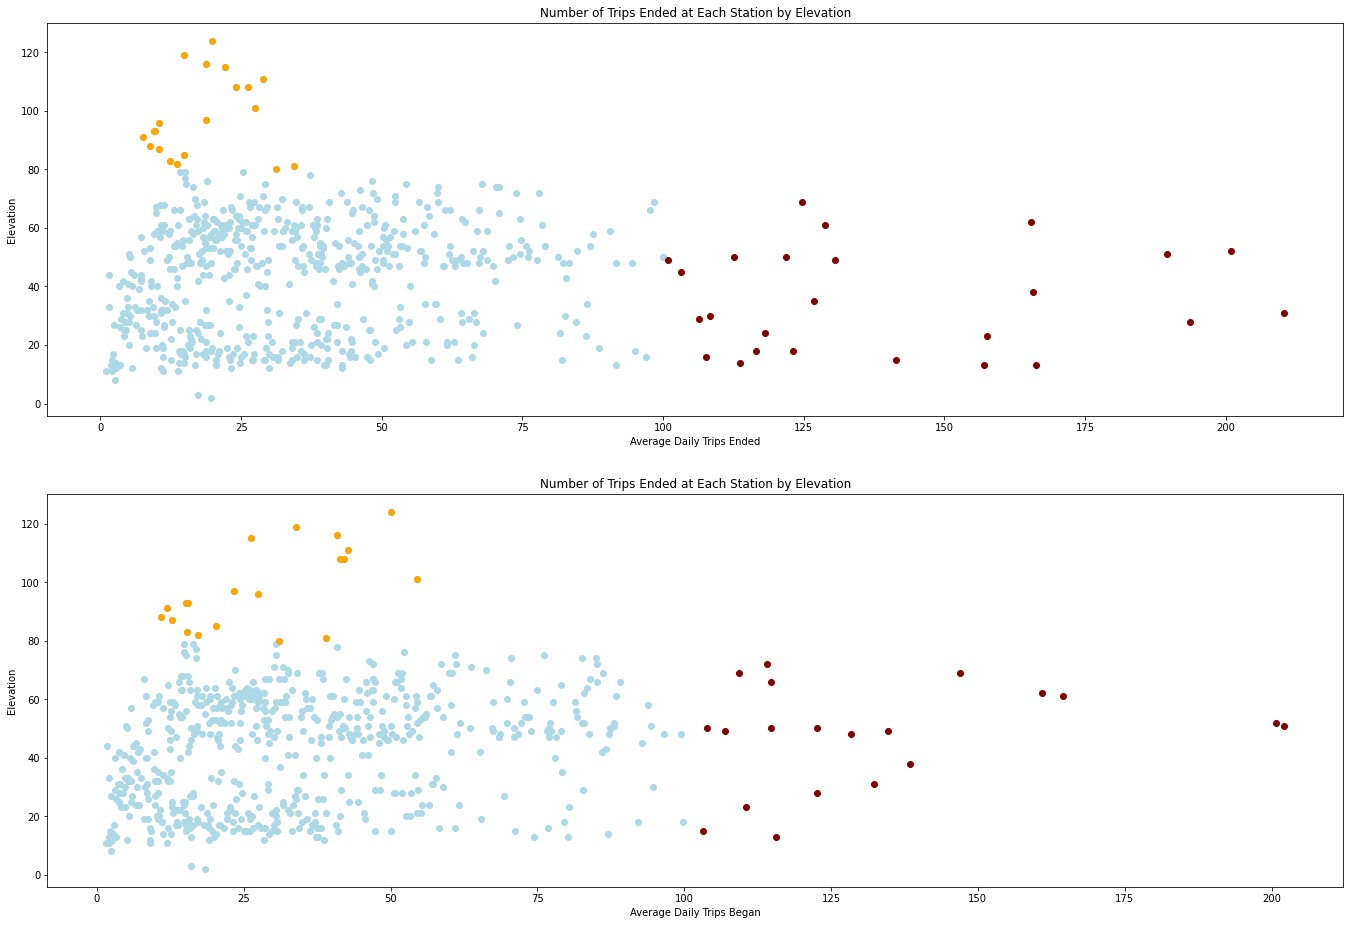

In [5]:
fig = plt.figure()
ax1 =  fig.add_subplot(211)
ax2 =  fig.add_subplot(212)
ax1.scatter(maps['trips_ended'][maps['trips_ended'] < 100],maps['altitude'][maps['trips_ended'] < 100],color = 'lightblue')
ax1.scatter(maps['trips_ended'][maps['trips_ended'] >= 100], maps['altitude'][maps['trips_ended'] >= 100], color = 'maroon')
ax1.scatter(maps['trips_ended'][maps['altitude'] >= 80], maps['altitude'][maps['altitude'] >= 80], color = 'orange')
ax1.set_xlabel('Average Daily Trips Ended')
ax1.set_ylabel('Elevation')
ax1.set_title('Number of Trips Ended at Each Station by Elevation')
ax1.set_xticks([0,25,50,75,100,125,150,175,200])

ax2.scatter(maps['trips_began'][maps['trips_began'] < 100],maps['altitude'][maps['trips_began'] < 100],color = 'lightblue')
ax2.scatter(maps['trips_began'][maps['trips_began'] >= 100], maps['altitude'][maps['trips_began'] >= 100], color = 'maroon')
ax2.scatter(maps['trips_began'][maps['altitude'] >= 80], maps['altitude'][maps['altitude'] >= 80], color = 'orange')
ax2.set_xlabel('Average Daily Trips Began')
ax2.set_ylabel('Elevation')
ax2.set_title('Number of Trips Ended at Each Station by Elevation')
plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0, hspace=0.2)
handles, labels = ax1.get_legend_handles_labels()

plt.show()

In [6]:
## Define a function that calaculates the distance to the central station using 
def distance_to_central(lat,long):
    #Radius of the earth
    R = 6373.0
    #Radians of central station coordinates
    c_lat = math.radians(45.5001)
    c_long = math.radians(-73.5665)
    
    dlat = c_lat - math.radians(lat)
    dlong = c_long - math.radians(long)
    
    a = math.sin(dlat / 2)**2 + math.cos(lat) * math.cos(c_lat) * math.sin(dlong / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance
maps['distance'] = 0

for i in maps.index:
    maps.loc[i,'distance'] = distance_to_central(maps.loc[i,'lat'] , maps.loc[i,'long'])


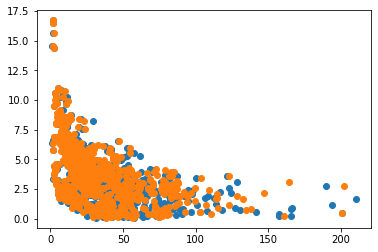

In [7]:
plt.scatter(maps['trips_ended'],maps['distance'])
plt.scatter(maps['trips_began'],maps['distance'])

# Graphing Total Trips over Time

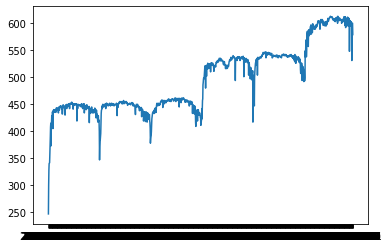

In [18]:
total = df.groupby('date')['trips_began','trips_ended'].apply(lambda x : x.astype(int).sum()).reset_index()
stations = df.groupby('date').station_code.count().reset_index()
stations.head()
#plt.plot(total['date'],total['trips_began'])
#plt.show()
plt.plot(stations['date'],stations['station_code'])
plt.show()